" Transfer learning consists of taking features learned on one problem, and leveraging them on a new, similar problem.

The most common incarnation of transfer learning in the context of deep learning is the following workflow:

- Take layers from a previously trained model.
- Freeze them, so as to avoid destroying any of the information they contain during future training rounds.
- Add some new, trainable layers on top of the frozen layers. They will learn to turn the old features into predictions on a new dataset.
- Train the new layers on your dataset.

A last, optional step, is fine-tuning, which consists of unfreezing the entire model you obtained above (or part of it), and re-training it on the new data with a very low learning rate. This can potentially achieve meaningful improvements, by incrementally adapting the pretrained features to the new data. "

-[Transfer learning & fine-tuning](https://keras.io/guides/transfer_learning/)

In this notebook, we will perform binary image classification to determine whether fruits are fresh or rotten using transfer learning. We'll train **EfficientNet [1]** on the **Fresh and Rotten Fruits Dataset for Machine-Based Evaluation of Fruit Quality [2]**.

Let's start by downloading the dataset. The code below downloads and extracts the dataset files.

In [ ]:
!wget https://data.mendeley.com/public-files/datasets/bdd69gyhv8/files/de93ba06-6a58-45e3-913d-837b2ae52acb/file_downloaded
!unzip /content/file_downloaded

Import the required libraries.

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import layers

We set the batch size and image size, then create lists of image paths for both classes.

In [9]:
IMAGE_SIZE = (260,260)
BATCH_SIZE = 32

In [4]:
fresh_paths = []
rotten_paths = []

for i in os.listdir("Original Image"):
  path = os.path.join("Original Image", i)
  if i[:5]=="Fresh":
    fresh_paths.extend([os.path.join(path,x) for x in os.listdir(path)])
  else:
    rotten_paths.extend([os.path.join(path,x) for x in os.listdir(path)])

Now, we use the `from_tensor_slices` method from `tensorflow` to create two datasets, one for fresh fruits and another for rotten fruits. We assign a label of **1** to fresh fruits and **0** to rotten fruits.

In [5]:
fresh_ds = tf.data.Dataset.from_tensor_slices((fresh_paths,np.ones(len(fresh_paths))))
rotten_ds = tf.data.Dataset.from_tensor_slices((rotten_paths, np.zeros(len(rotten_paths))))

Next, let's load the images and resize them to our required image size.

In [6]:
def process_path(file_path):
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  img = tf.image.resize(img, IMAGE_SIZE)
  return img

fresh_ds = fresh_ds.map(lambda x, y: (process_path(x),y))
rotten_ds = rotten_ds.map(lambda x, y: (process_path(x),y))

We concatenate the fresh and rotten datasets to create a combined dataset.

In [7]:
print("Samples in fresh dataset:", fresh_ds.cardinality().numpy())
print("Samples in rotten dataset:", rotten_ds.cardinality().numpy())
dataset = fresh_ds.concatenate(rotten_ds)
dataset = dataset.shuffle(3200)
print("Samples in entire dataset:", dataset.cardinality().numpy())

Samples in fresh dataset: 1600
Samples in rotten dataset: 1600
Samples in entire dataset: 3200


Let's divide our dataset into batches of images according to `BATCH_SIZE` using the `batch` method.

In [10]:
dataset = dataset.batch(BATCH_SIZE)

In [11]:
train_size = int(dataset.cardinality().numpy()*0.70)
test_size = int(dataset.cardinality().numpy()*0.15)
val_size = int(dataset.cardinality().numpy()*0.15)

In [12]:
train_size, test_size, val_size

(70, 15, 15)

We split the dataset into training, test, and validation sets using `take` and `skip` methods.

In [13]:
train_ds = dataset.take(train_size)
remain_ds = dataset.skip(train_size)
val_ds = remain_ds.take(val_size)
test_ds = remain_ds.skip(val_size)
print("Batches in training set:", train_ds.cardinality().numpy())
print("Batches in validation set:", val_ds.cardinality().numpy())
print("Batches in testing set:", test_ds.cardinality().numpy())

Batches in training set: 70
Batches in validation set: 15
Batches in testing set: 15


In `Keras`, each model requires input images to be processed in a specific way. Fortunately, the `preprocess_input` method associated with each model takes care of this for us. Let's apply this method to all our images.

In [14]:
train_ds = train_ds.map(lambda x, y: (keras.applications.efficientnet.preprocess_input(x), y))
val_ds = val_ds.map(lambda x, y: (keras.applications.efficientnet.preprocess_input(x), y))
test_ds = test_ds.map(lambda x, y: (keras.applications.efficientnet.preprocess_input(x), y))

Now, let's use data augmentation layers to expose our model to diverse image variations and enhance its overall generalization.

In [15]:
augmentation_layers = [
    layers.RandomRotation(0.2),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomZoom(0.2),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2)
]

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x

train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

The `prefetch` method loads the data required for the next step in memory, when the current step is being executed. It reduces the step time to the maximum (as opposed to the sum) of the training and the time it takes to extract the data. The `cache` method will cache the dataset and save some operations (like file opening and data reading) from being executed during each epoch.


In [14]:
train_ds = train_ds.prefetch(tf.data.AUTOTUNE).cache()
val_ds = val_ds.prefetch(tf.data.AUTOTUNE).cache()
test_ds = test_ds.prefetch(tf.data.AUTOTUNE).cache()

Let's load the EfficientNetB2 model into memory. We'll exclude the top layer since it classifies images based on ImageNet classes. Instead, we'll add our own layers: two `Dense` layers with `relu` activation functions, followed by a `Dense` layer with `softmax` activation for fresh versus rotten classification. To preserve the pre-trained weights, we'll set the EfficientNet layers as non-trainable.

In [16]:
base_model = keras.applications.EfficientNetB2(
    include_top=False,
    weights="imagenet",
    input_shape=IMAGE_SIZE+(3,)
)

base_model.trainable = False

x = layers.Flatten()(base_model.output)

x = layers.Dense(1024, activation='relu')(x)

x = layers.Dense(512, activation='relu')(x)

predictions = layers.Dense(2, activation='softmax')(x)

model = keras.Model(inputs=base_model.input, outputs=predictions)

model.summary(show_trainable=True)

31790344/31790344 [==============================] - 0s 0us/step
Model: "model"
_____________________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  Trainable  
 input_1 (InputLayer)        [(None, 260, 260, 3)]        0         []                            N          
                                                                                                             
 rescaling (Rescaling)       (None, 260, 260, 3)          0         ['input_1[0][0]']             N          
                                                                                                             
 normalization (Normalizati  (None, 260, 260, 3)          7         ['rescaling[0][0]']           N          
 on)                                                                                                         
                                        

We will compile the model using the `adam` optimizer, with `sparse_categorical_crossentropy` as the loss function and `sparse_categorical_accuracy` as the metric, since our labels are encoded as integers.

In [17]:
model.compile(optimizer=keras.optimizers.Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=[keras.metrics.SparseCategoricalAccuracy()])

We train our model for 10 epochs and save the model with the highest accuracy on validation set for future inference tasks.

In [18]:
epochs = 10

checkpoint_filepath = 'fresh_vs_rotten.weights.h5'

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    save_best_only=True)

history=model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[model_checkpoint_callback])

Epoch 1/10
70/70 [==============================] - 113s 1s/step - loss: 0.3094 - sparse_categorical_accuracy: 0.8589 - val_loss: 0.1326 - val_sparse_categorical_accuracy: 0.9438
Epoch 2/10
70/70 [==============================] - 106s 1s/step - loss: 0.1468 - sparse_categorical_accuracy: 0.9424 - val_loss: 0.0957 - val_sparse_categorical_accuracy: 0.9625
Epoch 3/10
70/70 [==============================] - 105s 1s/step - loss: 0.1087 - sparse_categorical_accuracy: 0.9607 - val_loss: 0.0655 - val_sparse_categorical_accuracy: 0.9854
Epoch 4/10
70/70 [==============================] - 101s 1s/step - loss: 0.1015 - sparse_categorical_accuracy: 0.9625 - val_loss: 0.0749 - val_sparse_categorical_accuracy: 0.9708
Epoch 5/10
70/70 [==============================] - 100s 1s/step - loss: 0.0839 - sparse_categorical_accuracy: 0.9661 - val_loss: 0.0611 - val_sparse_categorical_accuracy: 0.9792
Epoch 6/10
70/70 [==============================] - 100s 1s/step - loss: 0.0766 - sparse_categorical_accu

Now, let's plot the loss and accuracy curves. 

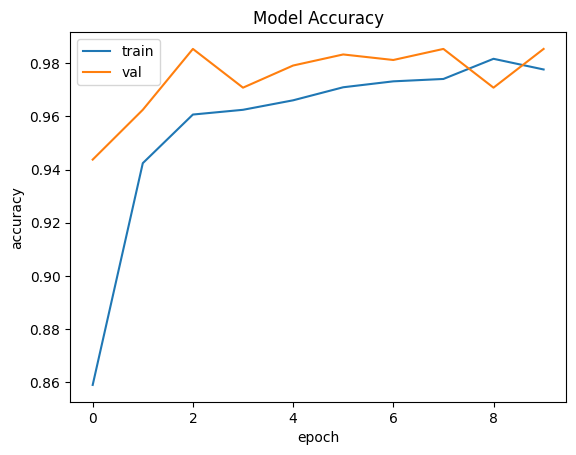

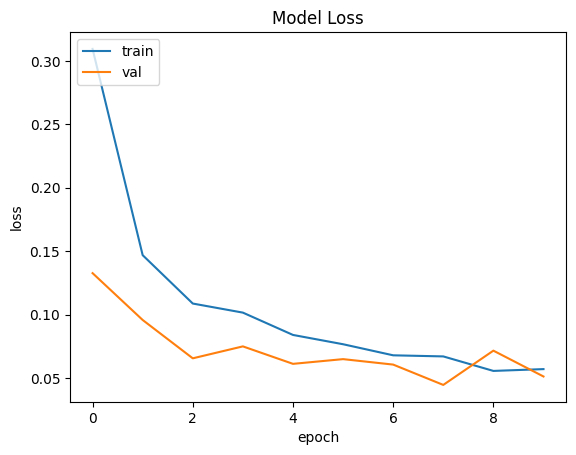

In [19]:
# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Finally, we evaluate our model on the test set.

In [20]:
model.load_weights('fresh_vs_rotten.weights.h5')
# Evaluate model on test set
loss, accuracy = model.evaluate(test_ds)
print('Test loss :', loss)
print('Test accuracy :', accuracy)

15/15 [==============================] - 14s 611ms/step - loss: 0.0980 - sparse_categorical_accuracy: 0.9563
Test loss : 0.0979643240571022
Test accuracy : 0.956250011920929


## References

[1]: Tan, M., & Le, Q.V. (2019). EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks. ArXiv, abs/1905.11946.

[2]: Sultana, Nusrat; Jahan, Musfika; Uddin, Mohammad Shorif (2022), “Fresh and Rotten Fruits Dataset for Machine-Based Evaluation of Fruit Quality”, Mendeley Data, V1, doi: 10.17632/bdd69gyhv8.1